## Exponential Distribution
---

The p.d.f. of an <font color=red>exponential distribution</font> $\mathrm{Exp}(\lambda)$ is

\begin{align*}
    & p(x|\lambda) = \lambda e^{-\lambda x}, \quad 0 < x < \infty,\quad \lambda > 0, \\
    & \mathrm{E}[X] = \frac1{\lambda},\quad \mathrm{Var}[X] = \frac1{\lambda^{2}}.
\end{align*}

The exponential distribution is used to model the length of duration.

## Likelihood
---

Suppose we have the i.i.d. sample $D=(x_{1},\dots,x_{n})$ from $\mathrm{Exp}(\lambda)$.

The likelihood is
\begin{align*}
    p(D|\lambda) &= \prod_{i=1}^{n}p(x_{i}|\lambda) = \prod_{i=1}^{n}\lambda e^{-\lambda x_{i}} \\
                 &= \lambda^{n}e^{-\lambda\sum_{i=1}^{n}x_{i}}.
\end{align*}

## Derivation of the Posterior Distribution of $\lambda$
---

We use the gamma distribution $\mathrm{Gamma}(\alpha_{0},\beta_{0})$ as the prior of $\lambda$.

The posterior distribution of $\lambda$ is derived as

\begin{align*}
    p(\lambda|D)
    &\propto p(D|\lambda)p(\lambda) \\
    &\propto \lambda^{n}e^{-\lambda\sum_{i=1}^{n}x_{i}}\times\lambda^{\alpha_{0}-1}e^{-\beta_{0}\lambda} \\
    &\propto \lambda^{n+\alpha_{0}-1}e^{-\left(\sum_{i=1}^{n}x_{i}+\beta_{0}\right)\lambda} \\
    &\propto \lambda^{\alpha_{\star}-1}e^{-\beta_{\star}\lambda}, \\
    \alpha_{\star} &= n + \alpha_{0},\quad \beta_{\star} = \sum_{i=1}^{n}x_{i} + \beta_{0},
\end{align*}

which is the gamma distribution $\mathrm{Gamma}(\alpha_{\star},\beta_{\star})$.


In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
from IPython.display import display

### HPDI of the gamma distribution

In [2]:
def gamma_hpdi(prob, alpha, theta, ci0=None):
    def hpdi_conditions(v, p, a, t):
        eq1 = st.gamma.cdf(v[1], a, scale=t) - st.gamma.cdf(v[0], a, scale=t) - p
        eq2 = st.gamma.pdf(v[1], a, scale=t) - st.gamma.pdf(v[0], a, scale=t)
        return np.hstack((eq1, eq2))
    if not ci0:
        ci0 = st.gamma.interval(prob, alpha, scale=theta)
    return opt.root(hpdi_conditions, ci0, args=(prob, alpha, theta)).x

### Posterior statsistics of $\lambda$

In [3]:
def exponential_stats(data, hyper_param, prob=0.95):
    a0 = hyper_param['a0']
    b0 = hyper_param['b0']
    n = data.size
    a_star = n + a0
    b_star = data.sum() + b0
    theta_star = 1.0 / b_star
    mean_lam = st.gamma.mean(a_star, scale=theta_star)
    median_lam = st.gamma.median(a_star, scale=theta_star)
    mode_lam = (a_star - 1.0) * theta_star
    sd_lam = st.gamma.std(a_star, scale=theta_star)
    ci_lam = st.gamma.interval(prob, a_star, scale=theta_star)
    hpdi_lam = gamma_hpdi(prob, a_star, theta_star)
    stats = np.hstack((mean_lam, median_lam, mode_lam, sd_lam, ci_lam, hpdi_lam)).reshape((1, 8))
    lower = 0.5 * (1.0 - prob) * 100.0
    upper = 0.5 * (1.0 + prob) * 100.0
    stats_string = ['mean', 'median', 'mode', 'sd',
                    f'ci ({lower:4.1f}%)', f'ci ({upper:4.1f}%)',
                    f'hpdi ({lower:4.1f}%)', f'hpdi ({upper:4.1f}%)']
    param_string = ['$\\lambda$']
    results = pd.DataFrame(stats, index=param_string, columns=stats_string)
    return results

### Plotting the posterior distribution of $\lambda$

In [4]:
def interactive_exponential_posterior_plot(data, hyper_param, bounds):
    a_slider = widgets.FloatLogSlider(min=-2.0, max=2.0, step=0.1, value=hyper_param['a0'], description='$\\alpha_{0}$:')
    b_slider = widgets.FloatLogSlider(min=-2.0, max=2.0, step=0.1, value=hyper_param['b0'], description='$\\beta_{0}$:')
    l = np.linspace(bounds[0], bounds[1], 1001)

    def exponential_posterior_plot(a0, b0):
        y = np.sum(data)
        a_star = data.size + a0
        b_star = y + b0
        prior_pdf = st.gamma.pdf(l, a0, scale=1.0/b0)
        posterior_pdf = st.gamma.pdf(l, a_star, scale=1.0/b_star)
        plt.figure(figsize=(8, 6))
        plt.plot(l, prior_pdf, label=f'Prior: Gamma({a0:.2f}, {b0:.2f})')
        plt.plot(l, posterior_pdf, label=f'Posterior: Gamma({a_star:.2f}, {b_star:.2f})')
        plt.xlabel('$\\lambda$')
        plt.ylabel('Probability Density')
        plt.title('Posterior Distribution for Exponential Distribution')
        plt.xlim(bounds)
        plt.ylim(0.0, 1.1 * np.max(posterior_pdf) if np.max(posterior_pdf) > 0 else 1.0)
        plt.legend(loc='best')
        plt.show()

    return widgets.interactive(exponential_posterior_plot, a0=a_slider, b0=b_slider)

## Application 1: Simulated Data
---

We use artificial data generated from the exponential distribution:

$$
 x_1,\dots,x_{50} \sim \mathrm{Exp}(3).
$$

The prior distribution of $\lambda$ is $\mathrm{Gamma}(1,1)$, which is equivalent to the exponential distribution:

$$
 p(\lambda) = e^{-\lambda},\quad \lambda > 0.
$$


In [5]:
rng = np.random.default_rng(seed=99)
lam, n = 3.0, 50
data = rng.exponential(scale=1.0/lam, size=n)
hyper_param = dict(
    a0 = 1.0,
    b0 = 1.0
)
results = exponential_stats(data, hyper_param)
display(results)

,mean,median,mode,sd,ci ( 2.5%),ci (97.5%),hpdi ( 2.5%),hpdi (97.5%)
$\lambda$,3.072358,3.052301,3.012116,0.430216,2.287573,3.9711,2.251364,3.927529


In [6]:
interactive_exponential_posterior_plot(data, hyper_param, (0.0, 6.0))

interactive(children=(FloatLogSlider(value=1.0, description='$\\alpha_{0}$:', max=2.0, min=-2.0), FloatLogSlid…

## Application2: Strikes Duration Data
---

+ a cross-section from 1968 to 1976
+ number of observations : 566
+ country : United States

### Variables:

+ dur - duration of the strike in days

+ gdp - measure of stage of business cycle (deviation of monthly log industrial production in manufacturing from prediction from OLS on time, time-squared and monthly dummies)

### Source:

Kennan, J. (1985) “The Duration of Contract strikes in U.S. Manufacturing”, Journal of Econometrics, 28, 5-28.

### Reference:

Cameron, A.C. and P.K. Trivedi (2005) Microeconometrics : methods and applications, Cambridge, pp. 574–5 and 582.

https://vincentarelbundock.github.io/Rdatasets/datasets.html


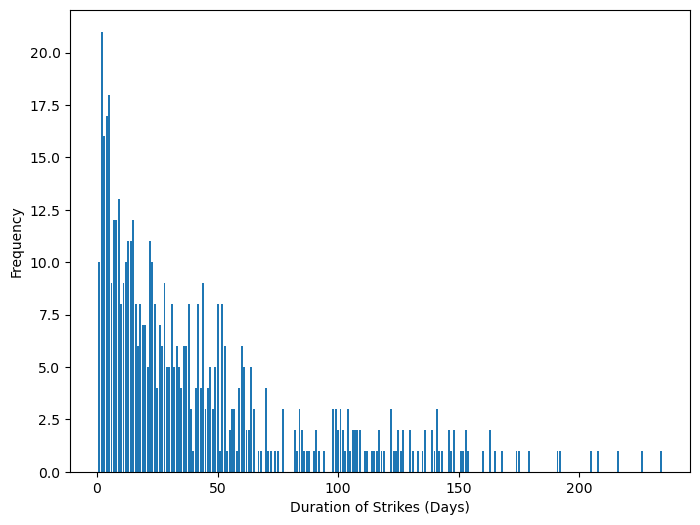

In [7]:
strikes_data = pd.read_csv('StrikeDur.csv', index_col=0)
strikes_duration = strikes_data['dur'].values
bin_max = np.max(strikes_duration)
hist, bins = np.histogram(strikes_duration, bins=np.linspace(1, bin_max, bin_max))
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], hist)
plt.xlabel('Duration of Strikes (Days)')
plt.ylabel('Frequency')
plt.show()

In [8]:
hyper_param_strikes = dict(
    a0 = 1.0,
    b0 = 1.0
)
results_strikes = exponential_stats(strikes_duration, hyper_param_strikes)
display(results_strikes)

,mean,median,mode,sd,ci ( 2.5%),ci (97.5%),hpdi ( 2.5%),hpdi (97.5%)
$\lambda$,0.022963,0.022949,0.022922,0.000964,0.021111,0.024891,0.021085,0.024863


In [9]:
interactive_exponential_posterior_plot(strikes_duration, hyper_param_strikes, (0.0, 0.04))

interactive(children=(FloatLogSlider(value=1.0, description='$\\alpha_{0}$:', max=2.0, min=-2.0), FloatLogSlid…